### 0. Imports and setup

In [1]:
from src.dataset import Colored3DMNIST, DataLoader
from torchvision import transforms, datasets
from IPython.display import clear_output
from matplotlib.colors import rgb2hex
from src.nn import UNet, ResNet_D
from src.plot import plot_img
from pathlib import Path
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.data as data
import torch.nn as nn
import numpy as np
import torchvision
import torch
import gc

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(f"cuda:0")
torch.manual_seed(42)
np.random.seed(42)

### 1. Getting the data ready

In [3]:
BATCH_SIZE = 32

def random_color(im):
    hue = np.random.choice([60, 120, 240, 280])
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

def Add_dimension(im):
    img_3D = torch.zeros(im.shape[0], im.shape[1], im.shape[2], 16)
    for i in range(im.shape[1]):
      if i < 4 or i > 12:
        img_3D[:, :, :, i] = torch.zeros_like(im)
      else:
        img_3D[:, :, :, i] = im
    return img_3D 

TRANSFORM_3D = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    Add_dimension,
])

# Load train datasets
mnist_train_a = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_a.targets == 3
mnist_train_a.data, mnist_train_a.targets = mnist_train_a.data[indices], mnist_train_a.targets[indices]

mnist_loader_a = torch.utils.data.DataLoader(mnist_train_a, batch_size=BATCH_SIZE, shuffle=True)


mnist_train_b = datasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM_3D)

indices = mnist_train_b.targets == 5
mnist_train_b.data, mnist_train_b.targets = mnist_train_b.data[indices], mnist_train_b.targets[indices]

mnist_loader_b = torch.utils.data.DataLoader(mnist_train_b, batch_size=BATCH_SIZE, shuffle=True)


mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM_3D)

indices = mnist_test.targets == 3
mnist_test.data, mnist_test.targets = mnist_test.data[indices], mnist_test.targets[indices]

mnist_loader_test = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

Let's plot a number:

In [4]:
def plot_img(img):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    color = np.array([rgb2hex(rgb) for rgb in img.numpy().reshape(3, -1).T])
    color = color.reshape(*img.shape[1:])
    
    if torch.any(img[0, ...]):
        img = img[0, ...]
    elif torch.any(img[1, ...]):
        img = img[1, ...]
    else:
        img = img[2, ...]
    
    ax.voxels(img, facecolors=color)
    plt.show()


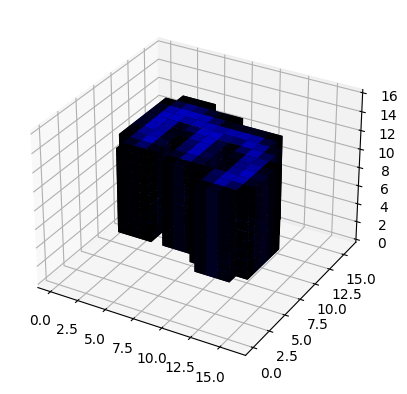

In [5]:
plot_img(next(iter(mnist_train_a))[0])

### 3. Preparation for the training

In [6]:
# Taken from https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/src/tools.py
def weights_init_D(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        
def weights_init_mlp(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

In [14]:
f = ResNet_D(16, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3).cuda()

In [15]:
iter_train_a = iter(mnist_loader_a)
iter_train_b = iter(mnist_loader_b)
iter_test = iter(mnist_loader_test)

def sample_train_a():
    global mnist_loader_a, iter_train_a
    try:
        return next(iter_train_a)[0]
    except StopIteration:
        iter_train_a = iter(mnist_loader_a)
        return next(iter_train_a)[0]

def sample_train_b():
    global mnist_loader_b, iter_train_b
    try:
        return next(iter_train_b)[0]
    except StopIteration:
        iter_train_b = iter(mnist_loader_b)
        return next(iter_train_b)[0]

def sample_test():
    global mnist_loader_test, iter_test
    try:
        return next(iter_test)[0]
    except StopIteration:
        iter_test = iter(mnist_loader_test)
        return next(iter_test)[0]

In [16]:
def save_model(e, t, F, o_t, o_F, l_t, l_F, path):
    torch.save({
                'epoch': e,
                'T_state_dict': t.state_dict(),
                'f_state_dict': F.state_dict(),
                'T_optimizer_state_dict': o_t.state_dict(),
                'f_optimizer_state_dict': o_F.state_dict(),
                'T_loss': l_t,
                'f_loss': l_F
                }, path)

In [17]:
T_opt = torch.optim.Adam(T.parameters(), lr=1e-5, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=1e-4, weight_decay=1e-10)

### 4. Training loop

In [18]:
def sq_cost(X, Y):
  return (X-Y).square().flatten(start_dim=1).mean(dim=1)

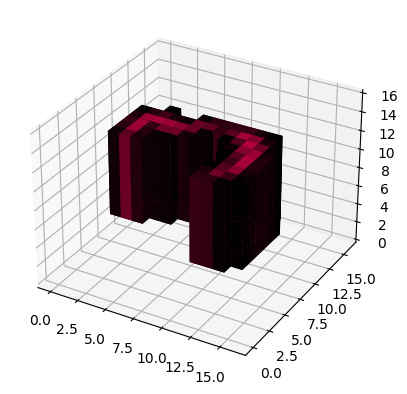

  0%|          | 0/4001 [00:00<?, ?it/s]

T_loss: 0.14437200129032135;  f_loss: -0.0023951828479766846


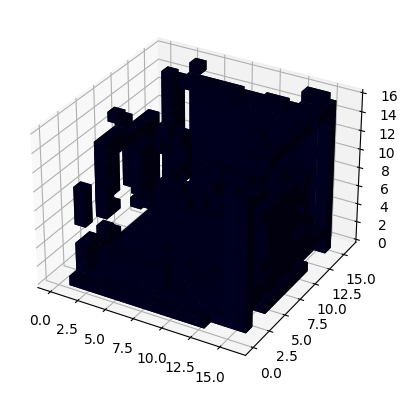

  2%|▏         | 100/4001 [01:09<44:25,  1.46it/s]

T_loss: -0.028183208778500557;  f_loss: -0.004322022199630737


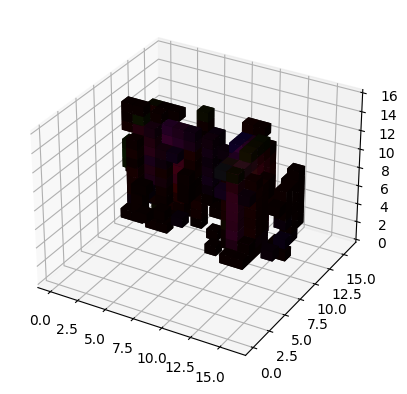

  5%|▍         | 200/4001 [02:18<43:46,  1.45it/s]

T_loss: -0.031087525188922882;  f_loss: -0.003959309309720993


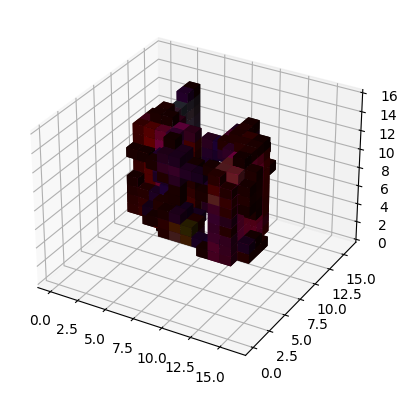

  7%|▋         | 300/4001 [03:27<42:34,  1.45it/s]

T_loss: 0.3260977268218994;  f_loss: 0.006257534027099609


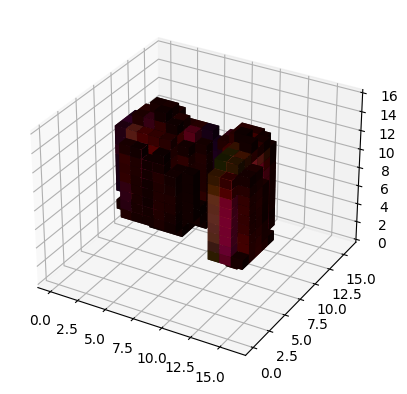

 10%|▉         | 400/4001 [04:37<41:35,  1.44it/s]

T_loss: -0.220256969332695;  f_loss: -0.014802157878875732


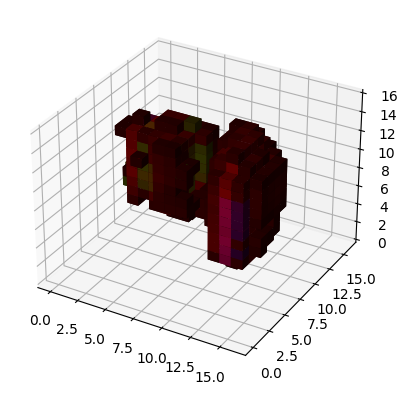

 12%|█▏        | 500/4001 [05:46<40:21,  1.45it/s]

T_loss: -0.6085675358772278;  f_loss: -0.17495715618133545


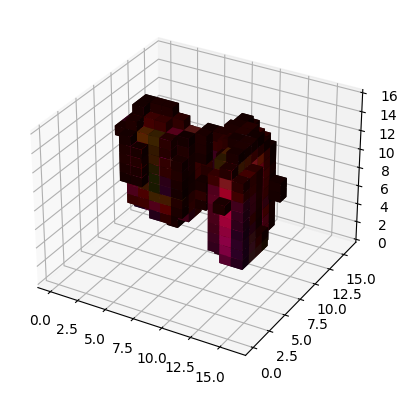

 15%|█▍        | 600/4001 [06:56<39:12,  1.45it/s]

T_loss: 0.9667792916297913;  f_loss: -0.18062257766723633


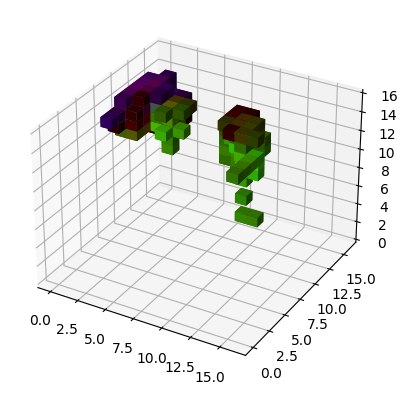

 17%|█▋        | 700/4001 [08:05<37:52,  1.45it/s]

T_loss: -1.5173262357711792;  f_loss: -0.13528680801391602


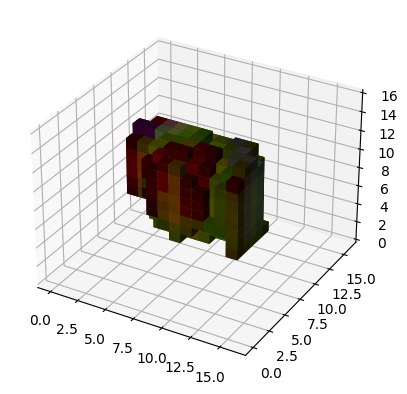

 20%|█▉        | 800/4001 [09:15<36:55,  1.45it/s]

T_loss: -0.46146446466445923;  f_loss: -0.018923938274383545


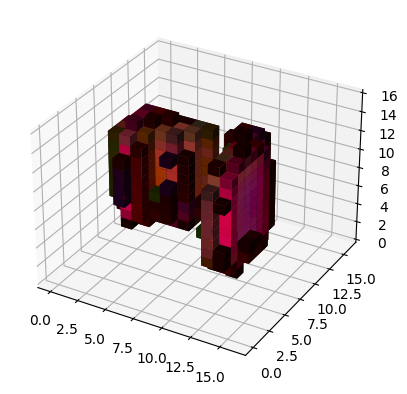

 22%|██▏       | 900/4001 [10:24<35:45,  1.45it/s]

T_loss: -1.5175484418869019;  f_loss: 0.01203930377960205


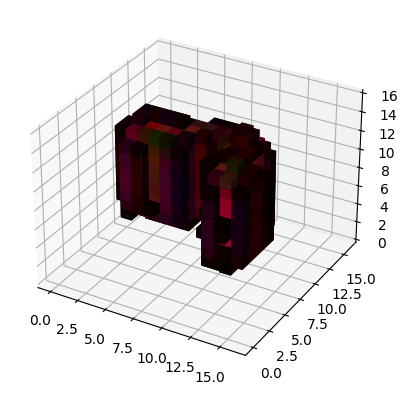

 25%|██▍       | 1000/4001 [11:34<34:34,  1.45it/s]

T_loss: 0.2264874130487442;  f_loss: -0.1177973672747612


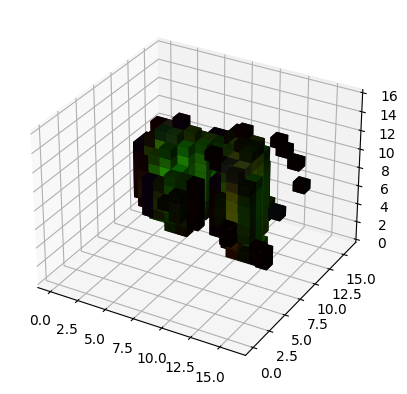

 27%|██▋       | 1100/4001 [12:44<33:13,  1.46it/s]

T_loss: -1.166961908340454;  f_loss: 0.16074538230895996


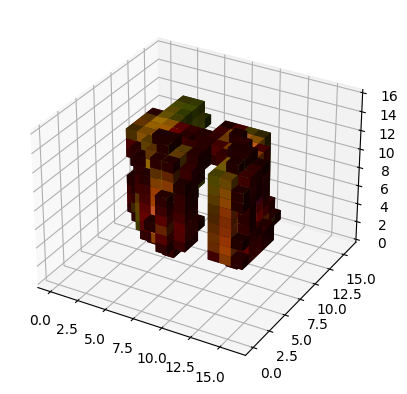

 30%|██▉       | 1200/4001 [13:53<32:17,  1.45it/s]

T_loss: -0.08527939766645432;  f_loss: -0.008846238255500793


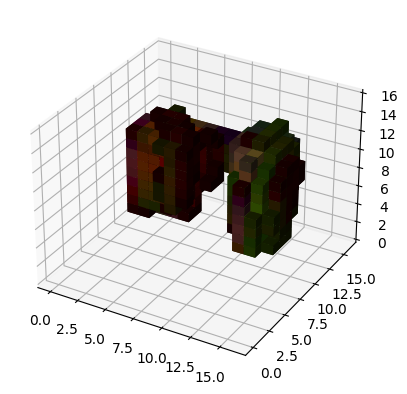

 32%|███▏      | 1300/4001 [15:03<31:08,  1.45it/s]

T_loss: -0.4276752471923828;  f_loss: -0.009964406490325928


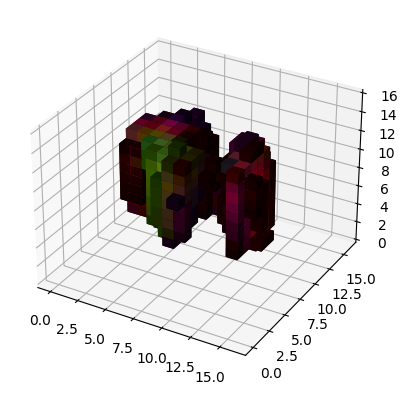

 35%|███▍      | 1400/4001 [16:12<29:56,  1.45it/s]

T_loss: -0.36511456966400146;  f_loss: -0.009707480669021606


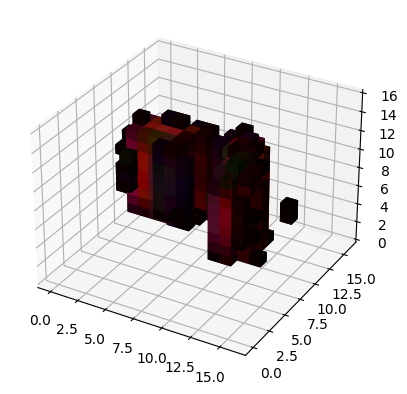

 37%|███▋      | 1500/4001 [17:22<28:51,  1.44it/s]

T_loss: -0.4474956691265106;  f_loss: -0.010872572660446167


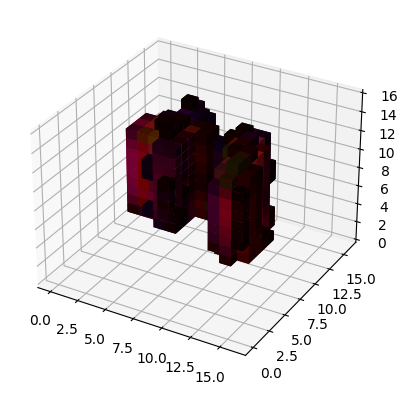

 40%|███▉      | 1600/4001 [18:31<27:41,  1.45it/s]

T_loss: -0.35039255023002625;  f_loss: -0.019366860389709473


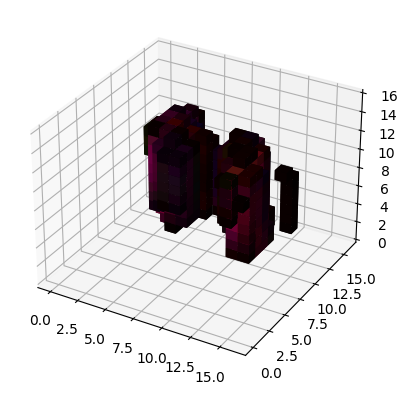

 42%|████▏     | 1700/4001 [19:41<26:13,  1.46it/s]

T_loss: -0.15173564851284027;  f_loss: -0.019288554787635803


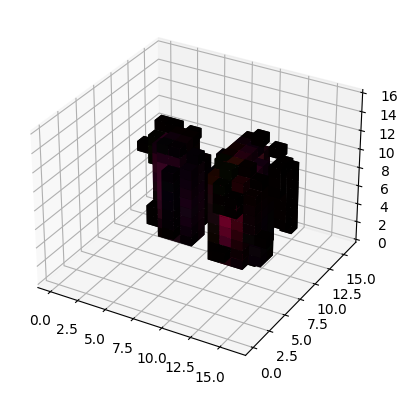

 45%|████▍     | 1800/4001 [20:50<25:18,  1.45it/s]

T_loss: -0.026425711810588837;  f_loss: -0.004899434745311737


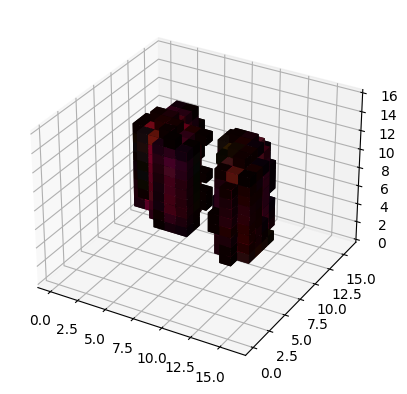

 47%|████▋     | 1900/4001 [22:00<24:14,  1.44it/s]

T_loss: 0.26485541462898254;  f_loss: 0.0008956342935562134


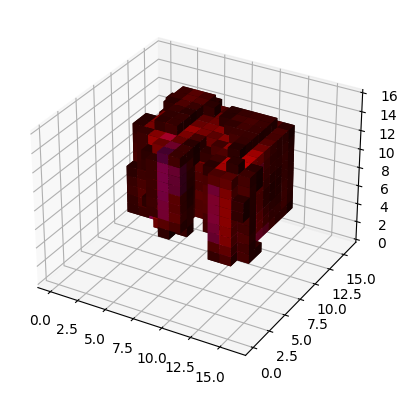

 50%|████▉     | 2000/4001 [23:10<23:04,  1.45it/s]

T_loss: 0.1605338752269745;  f_loss: -0.01014845073223114


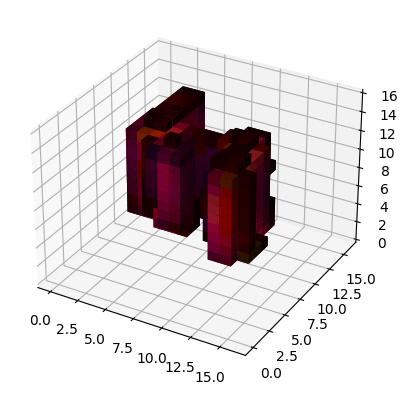

 52%|█████▏    | 2100/4001 [24:19<21:54,  1.45it/s]

T_loss: 0.04469304159283638;  f_loss: -0.011333426460623741


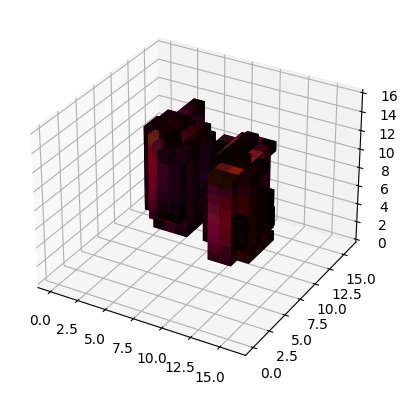

 55%|█████▍    | 2200/4001 [25:29<20:37,  1.46it/s]

T_loss: -5.029286861419678;  f_loss: 0.1969304084777832


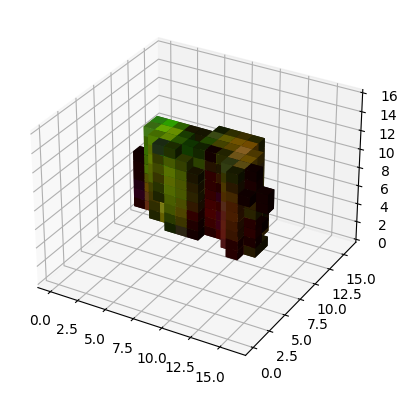

 57%|█████▋    | 2300/4001 [26:38<19:37,  1.44it/s]

T_loss: -0.18342873454093933;  f_loss: -0.005560398101806641


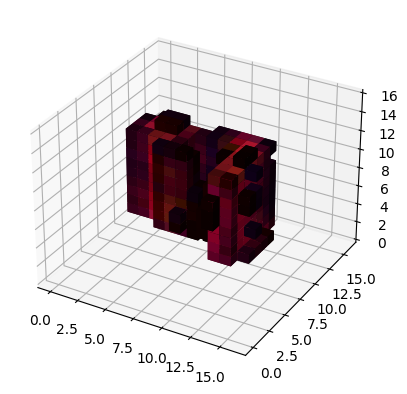

 60%|█████▉    | 2400/4001 [27:48<18:27,  1.45it/s]

T_loss: -0.6419845223426819;  f_loss: 0.003128647804260254


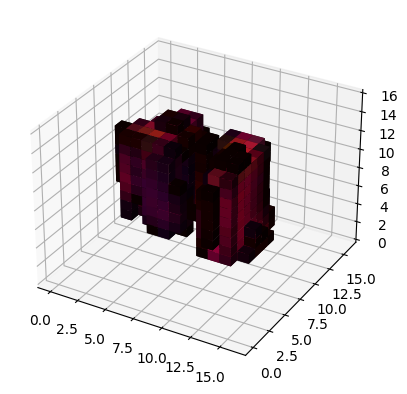

 62%|██████▏   | 2500/4001 [28:57<17:17,  1.45it/s]

T_loss: -0.4645484685897827;  f_loss: -0.011361420154571533


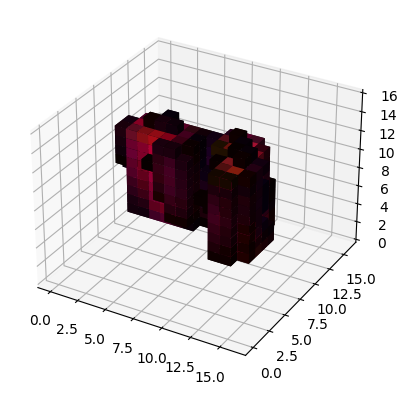

 65%|██████▍   | 2600/4001 [30:07<16:09,  1.44it/s]

T_loss: -0.6117724180221558;  f_loss: -0.00757986307144165


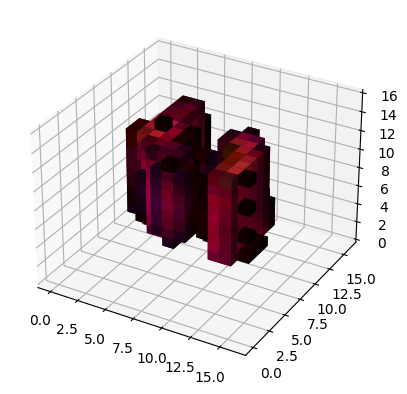

 67%|██████▋   | 2700/4001 [31:17<15:00,  1.44it/s]

T_loss: -1.1843907833099365;  f_loss: 0.08289909362792969


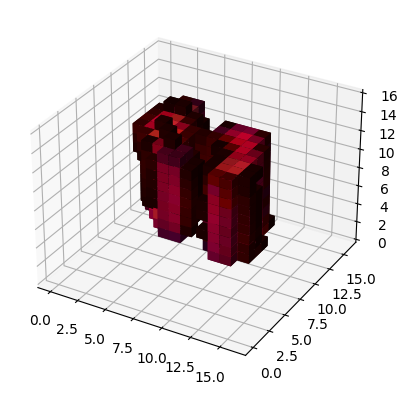

 70%|██████▉   | 2800/4001 [32:26<13:50,  1.45it/s]

T_loss: -0.23578228056430817;  f_loss: -0.05498495697975159


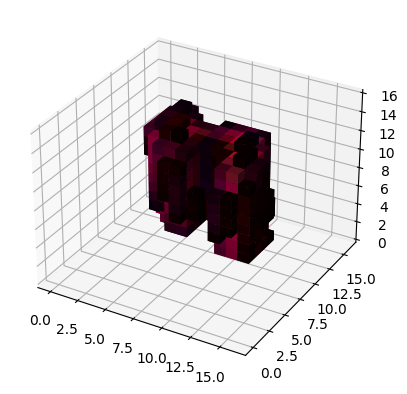

 72%|███████▏  | 2900/4001 [33:36<12:39,  1.45it/s]

T_loss: -185.74755859375;  f_loss: 115.12680053710938


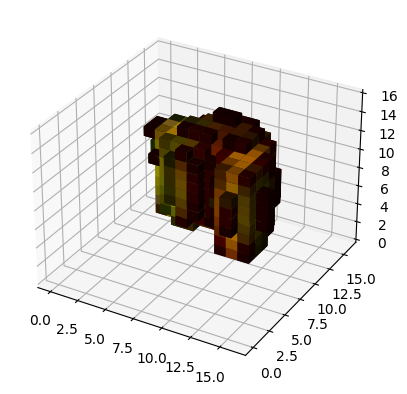

 75%|███████▍  | 3000/4001 [34:45<11:32,  1.45it/s]

T_loss: 0.10754571855068207;  f_loss: -0.0998729020357132


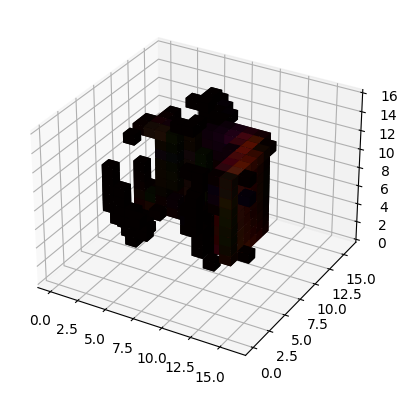

 77%|███████▋  | 3100/4001 [35:55<10:23,  1.45it/s]

T_loss: -0.18854109942913055;  f_loss: -0.27264899015426636


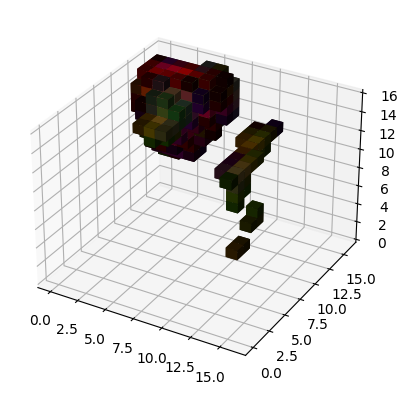

 80%|███████▉  | 3200/4001 [37:04<09:14,  1.45it/s]

T_loss: 0.01590852253139019;  f_loss: -0.03036247007548809


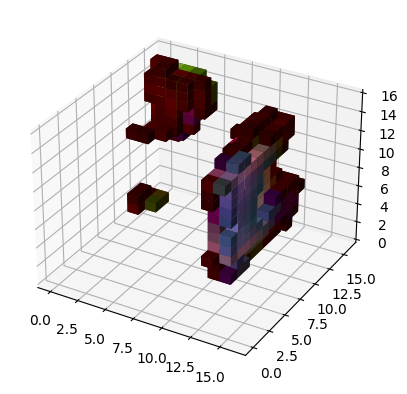

 82%|████████▏ | 3300/4001 [38:14<08:02,  1.45it/s]

T_loss: -0.8454064726829529;  f_loss: -0.02589261531829834


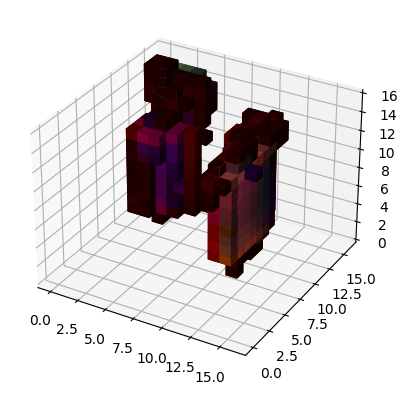

 85%|████████▍ | 3400/4001 [39:23<06:51,  1.46it/s]

T_loss: -0.9724962711334229;  f_loss: -0.023339927196502686


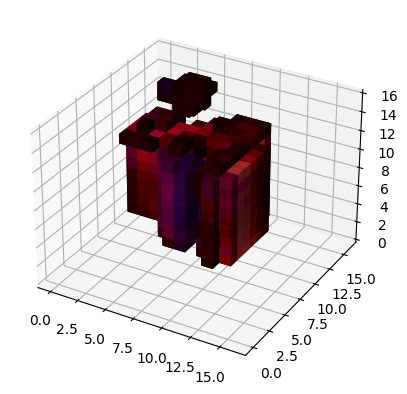

 87%|████████▋ | 3500/4001 [40:33<05:46,  1.45it/s]

T_loss: -0.9473206400871277;  f_loss: 0.031645774841308594


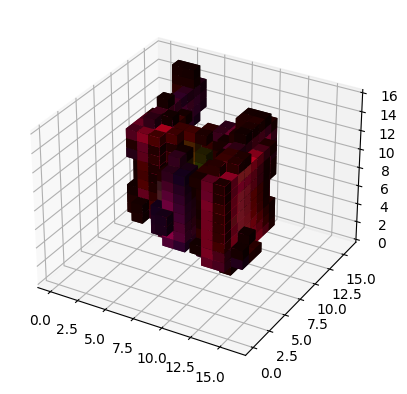

 90%|████████▉ | 3600/4001 [41:42<04:36,  1.45it/s]

T_loss: -0.47927990555763245;  f_loss: 0.0013180077075958252


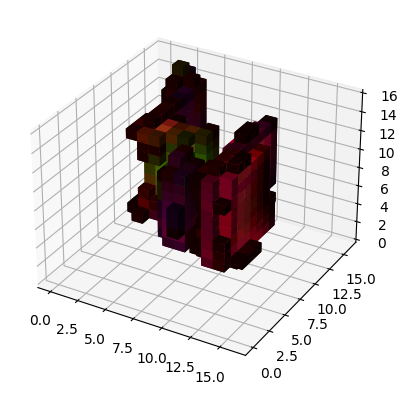

 92%|█████████▏| 3700/4001 [42:52<03:28,  1.44it/s]

T_loss: -0.37580615282058716;  f_loss: 0.004357665777206421


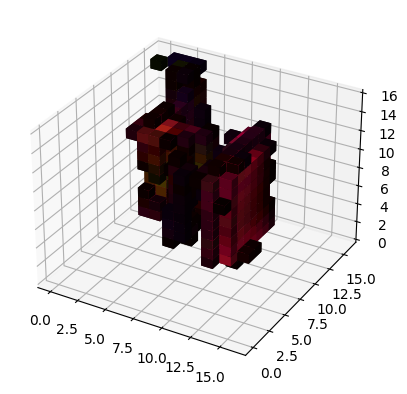

 95%|█████████▍| 3800/4001 [44:02<02:19,  1.44it/s]

T_loss: -0.3972384035587311;  f_loss: 0.007674872875213623


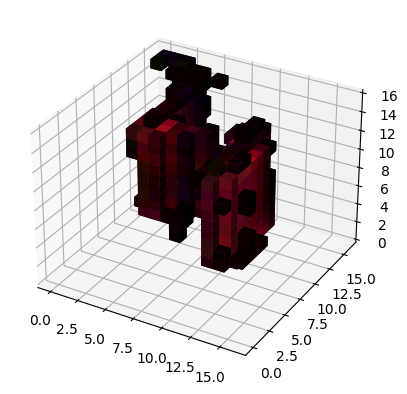

 97%|█████████▋| 3900/4001 [45:11<01:09,  1.45it/s]

T_loss: -0.30692678689956665;  f_loss: 0.00602450966835022


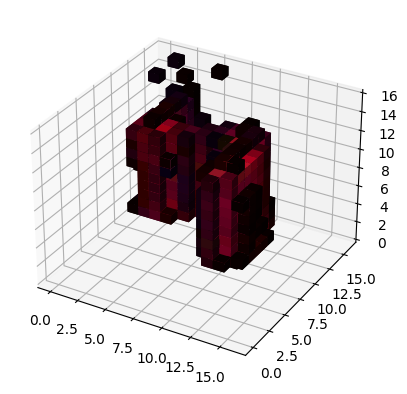

100%|█████████▉| 4000/4001 [46:21<00:00,  1.45it/s]

T_loss: -0.2055564820766449;  f_loss: -0.0017919689416885376


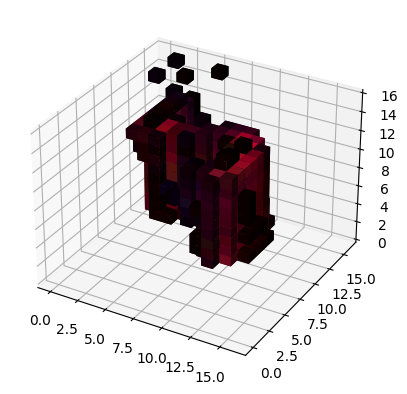

100%|██████████| 4001/4001 [46:22<00:00,  1.44it/s]


In [19]:
test_batch = sample_test()
plot_img(test_batch[0])
f_losses = []
T_losses = []

imgs = []

for step in tqdm(range(4001)):
    # clear_output(wait=True)

    # Training T, freezing f
    T.train(True)
    f.eval()
    
    for i in range(10):
        X = sample_train_a().cuda()

        T_X = T(X)
        T_loss = sq_cost(X, T_X).mean() - f(T_X).mean()
        T_opt.zero_grad()
        T_loss.backward()
        T_opt.step()
    

    # Training f, freezing T
    f.train(True)
    T.eval()

    X = sample_train_a().cuda()
    Y = sample_train_b().cuda()

    with torch.no_grad():
        T_x = T(X)
    
    f_loss = f(T_x).mean() - f(Y).mean()
    f_opt.zero_grad()
    f_loss.backward()
    f_opt.step()

    if not step % 100:
        print(f"T_loss: {T_loss}; ", end="")
        print(f" f_loss: {f_loss}")
        T_X = torch.clip(T(test_batch.cuda())[0].cpu().detach(), min=0, max=1)
        T_X[T_X < np.quantile(T_X, 0.92)] = 0
        plot_img(T_X)

    # Save OT map every 1000 steps
    if not step % 1000:
        save_model(step, T, f, T_opt, f_opt, T_loss, f_loss, f"weights/OT_{step}.pt")

    gc.collect()
    torch.cuda.empty_cache()

In [20]:
test_batch = sample_test().cuda()

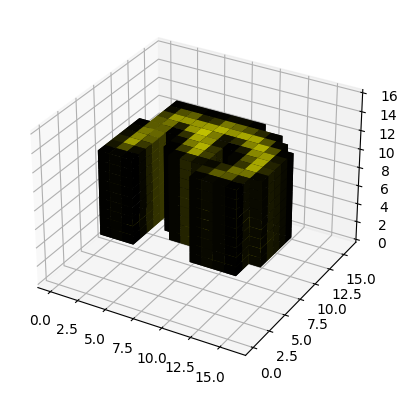

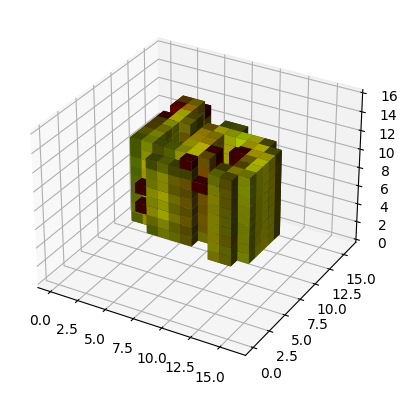

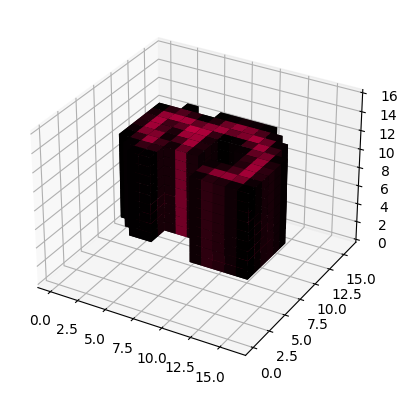

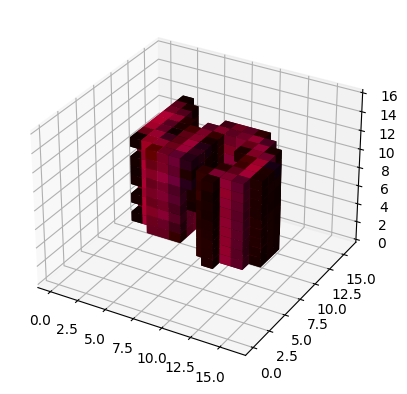

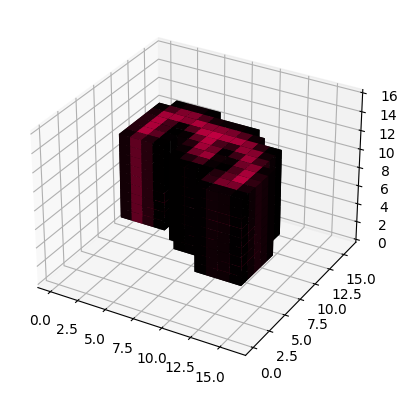

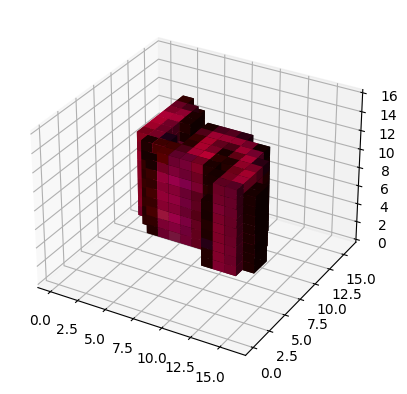

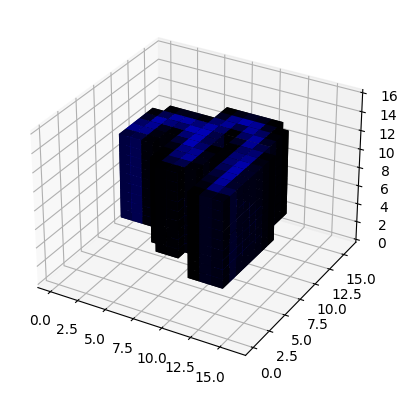

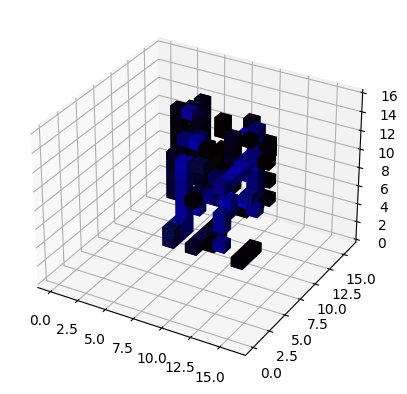

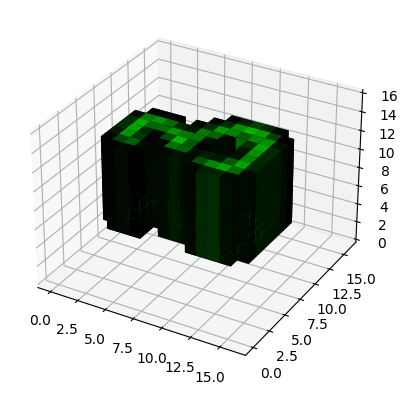

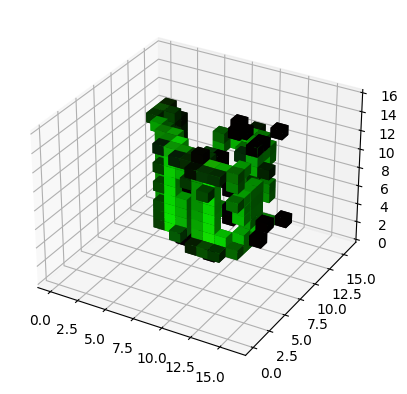

In [21]:
for i in range(5):
    plot_img(test_batch[i].cpu())

    T_X = torch.clip(T(test_batch)[i].cpu().detach(), min=0, max=1)
    T_X[T_X < np.quantile(T_X, 0.92)] = 0
    plot_img(T_X)